In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('../data/processed_data/merged_characteristics_2016.csv')
df2 = pd.read_csv('../data/processed_data/merged_characteristics_2017.csv')

########create mkt share data for logit
logit_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices', 'demand_instruments0']
nonlinear_cols = ['EHBPercentTotalPremium']
linear_cols = [ 'act_value','MetalLevel_Platinum', 'MetalLevel_Silver','Plan Counts']
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE','S1701_C01_017E','StateCodeFL'] 
firm_cols =  linear_cols+ nonlinear_cols   
logit_x_cols = firm_cols + mkt_cols + ['DP03_0095E']


############keys for boosted trees...
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']
missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%','FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']

#setup y
y_cols = ['Ever Enrolled Count']
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

In [3]:
def create_logit_data(df):
    df = df.copy()
    
    #create market data...
    df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']
    #add logit columns
    df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 

    #demand_instrument0
    MktIds = np.array(pd.get_dummies(df['IssuerId']))
    MktIds2 = (MktIds.T).dot(MktIds)
    dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
    df['demand_instruments0'] = dummies_proj.dot(df['PREMI27']) #average price across markets

   
    #fix problematic columns
    df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                      'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                           'Total Number of Consumers':'csr_tot',
                            'Number of Consumers with CSR AV of 94%':'csr_tot_94'
                           ,'PREMI27':'prices', 'County':'market_ids', 'IssuerId':'firm_ids'})
    
    #standardize the cols
    for col in firm_cols:
        df[col] = df[col]/df[col].std()
    df = df[df['shares']!=0]
    
    
    ######### preprocess lasso data
    lasso_x_cols = ['prices']

    for col in df.columns:
        if (col not in y_cols and col not in keys and col not in missing_cols 
            and not 'StateCode' in col and not 'IssuerId' in col and 'csr_' not in col
            and col not in logit_keys and col not in logit_x_cols):
                df[col] = df[col]/df[col].std()
                lasso_x_cols.append(col) 
    
    df = df.fillna(0)
    
    all_cols = list(set(logit_keys + logit_x_cols + y_cols+lasso_x_cols+logit_x_cols))
    clean_df = df[all_cols]
    return sm.add_constant(clean_df),lasso_x_cols


clean_df1,lasso_x_cols = create_logit_data(df1) #note the 2016 data needs to come first
clean_df2,_ = create_logit_data(df2)

/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [4]:
X_train = clean_df1[lasso_x_cols+logit_x_cols]
X_train = X_train/X_train.std()

X_test = clean_df2[lasso_x_cols+logit_x_cols]
X_test = X_test/X_test.std()
X_test = X_test.fillna(0)

y_train = clean_df1[y_cols]
y_test = clean_df2[y_cols]

In [5]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_test < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df2, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

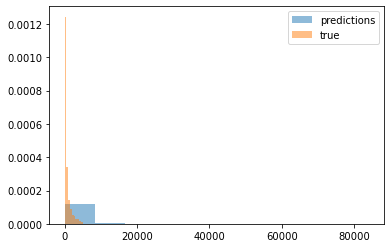

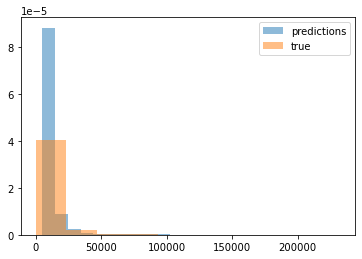

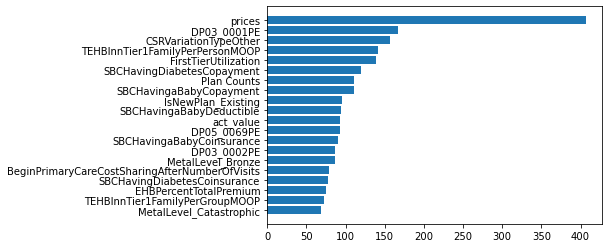

mse 27013648.647753585 r2 0.3291774054360411 var 40269437.65260727
pred 2016 9871426.0 actual 2016 9870266.0
pred mean 2016 1231.3118 mean 2016 1231.167020082325
pred 2017 17371188.0 actual 2017 9167619.0
pred mean 2017 3203.833984375 actual 2017 1690.8187015861306


In [6]:
params = [(5,.1,.5,.5)]


for param in params:
    mses = []
    r2s = []
    np.random.seed(3)
    # not super deep, but uses most of the data at one
    model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                         eta=param[1], subsample=param[2], colsample_bytree=param[3])
    model.fit(X_train, y_train)

    y_pred = get_predictions(model,X_test)
    mse = float( ((y_test - y_pred)**2).mean() )
    r2 = float(  1- mse/y_test.var() )

    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    plot_importance(X_test,model)
            
    #report fit statistics
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', mse ,'r2', 1 - float(mse/y_test.var()), 'var', float(y_test.var()) )
    
    print( 'pred 2016', get_predictions(model,X_train).sum(),
          'actual 2016', float(y_train.sum()))
    print( 'pred mean 2016', get_predictions(model,X_train).mean(),
          'mean 2016', float(y_train.mean()))
    
    print('pred 2017', float(y_pred.sum()), 'actual 2017', float(y_test.sum()))
    print('pred mean 2017', float(y_pred.mean()), 'actual 2017', float(y_test.mean()))

mse 26552848.585823376 r2 0.34062032812856535 var 40269437.65260727
pred 2016 9871426.0 actual 2016 9870266.0
pred mean 2016 1231.3118 mean 2016 1231.167020082325
pred 2017 8661166.227858983 actual 2017 9167619.0
pred mean 2017 1597.411698240314 mean 2017 1690.8187015861306


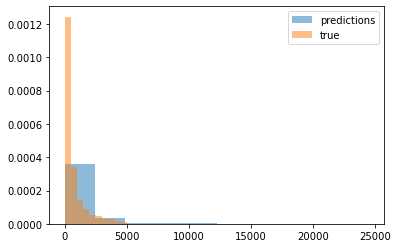

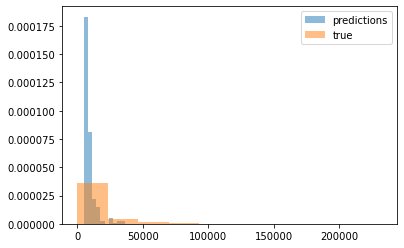

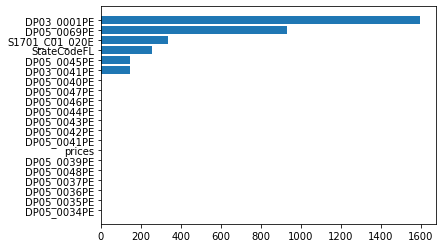

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     29120.477382        102128.000000           NaN           NaN
IL     22348.686627         53300.500000  20360.022050  32616.714496
NV     17235.374044         47506.000000           NaN           NaN
TX     16140.994349         57073.888889  10176.561070  34834.845153
FL     15600.164638         68909.416667   5917.511002  58075.794157
VA      9825.532263         35581.000000           NaN           NaN
UT      7675.495937         32160.333333   3084.376863   7605.002980
PA      7622.172713         33730.000000   2956.828305   8895.247308
WI      7573.782077         26755.000000           NaN           NaN
GA      7123.773179         34179.750000   1184.892772  12126.440901
MO      6554.935466         33361.000000           NaN           NaN
NC      5726.871542         40277.250000   2961.653354  19389.082622
OK      5632.116568         29752.

In [7]:
# Vary alpha values
a = [250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,np.array(X_test))
    
    mse = float(((y_test - y_pred)**2).mean())
    r2 = float( 1 - mse/y_test.var() )
    print( 'mse', mse ,'r2', 1 - float(mse/y_test.var()), 'var', float(y_test.var()) )
    
    print( 'pred 2016', get_predictions(model,X_train).sum(),
          'actual 2016', float(y_train.sum()))
    print( 'pred mean 2016', get_predictions(model,X_train).mean(),
          'mean 2016', float(y_train.mean()))
    
    print('pred 2017', float(y_pred.sum()), 'actual 2017', float(y_test.sum()))
    print('pred mean 2017', float(y_pred.mean()), 'mean 2017', float(y_test.mean()))
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()
    print(report_error(y_test,y_pred))
    print('==========================================')
    print('==========================================')